In [15]:
# import
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import zipfile
import os
import folium

In [16]:
# load dataset
earthquakes = pd.read_csv('earthquake_merged2.csv')
eq = earthquakes.dropna(subset=['Latitude', 'Longitude'])

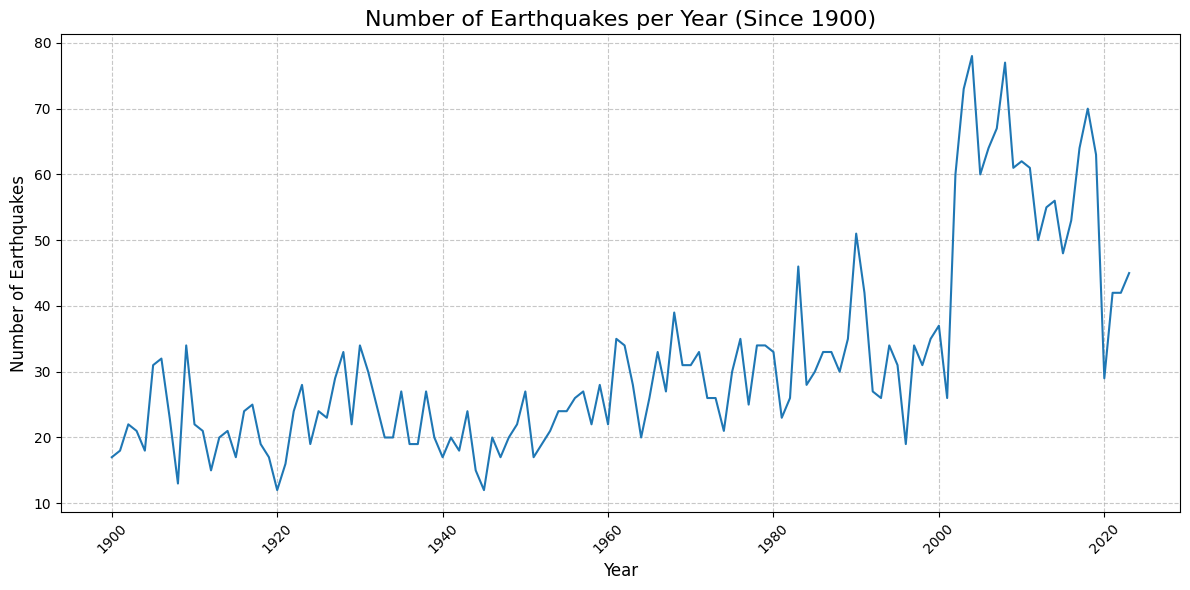

In [17]:
# Group earthquakes by year and count
earthquakes_per_year = eq[(eq['Year'] >= 1900) & (eq['Year'] < 2024)].groupby('Year').size().reset_index(name='Number of Earthquakes')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(earthquakes_per_year['Year'], earthquakes_per_year['Number of Earthquakes'])

# Customize the plot
plt.title('Number of Earthquakes per Year (Since 1900)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

This is a time series plot of earthquake existences since 1900. The occurences of earthquakes appear to be cyclical from 1900 to 2000, which makes sense given the earthquake cycle, which is the phenomeon explaining that earthquakes exist on the same faults repeatedly due to the build up of stress. Around 2000, we see a large jump in earthquake occurrences. This is likely due to the fact that technology to record earthquakes has improved, as smaller earthquakes and earthquakes occurring deeper in the Earth can be recorded. Because of this, we have decided to concentrate our visualizations on this portion of the dataset, since the quality of data is much higher.

In [18]:
alt.Chart(eq).mark_bar().encode(
    alt.X('Mag:Q', bin = alt.BinParams(maxbins = 10)),
    alt.Y('count()')
)

alt.Chart(...)

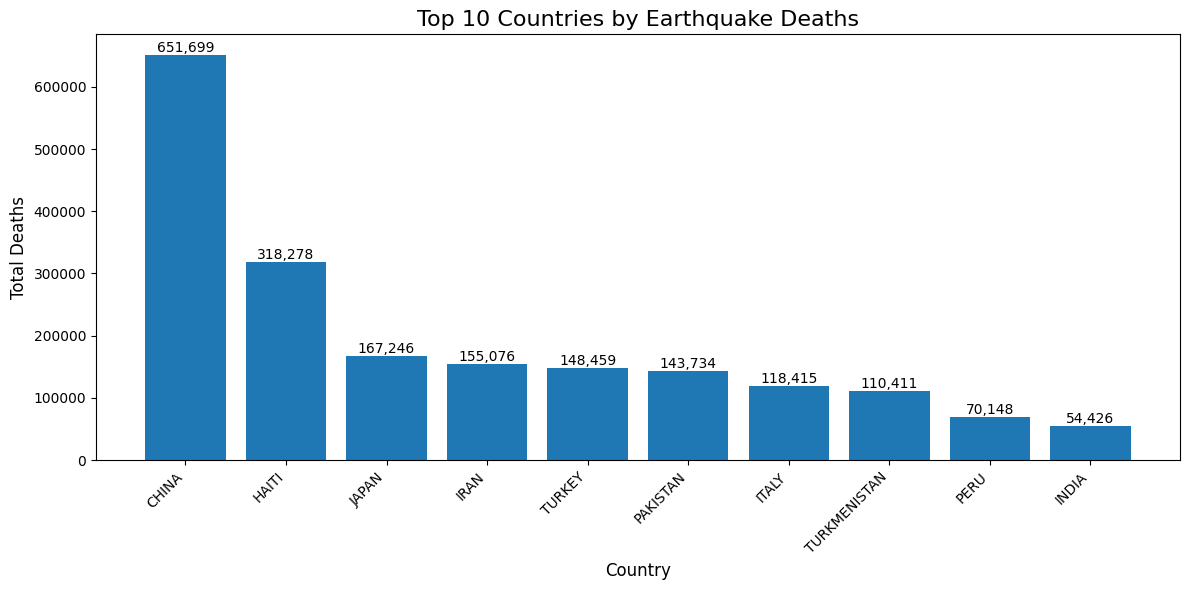

In [19]:
# Top 10 earthquake deaths per country

# Group the data by country and sum the deaths
eq_deaths = eq.groupby('Country Name')['Deaths'].sum().reset_index()

top_10_countries = eq_deaths.sort_values('Deaths', ascending=False).head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_10_countries['Country Name'], top_10_countries['Deaths'])
plt.title('Top 10 Countries by Earthquake Deaths', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of each bar
for i, v in enumerate(top_10_countries['Deaths']):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.show()

This is a bar chart showing the top ten countries by earthquake deaths. As we can see, China has the most deaths by earthquakes by a wide margin with 651,699. Haiti is second in earthquake deaths, though most of these deaths are due to the deadly 2010 earthquake, suggesting that other earthquakes in Haiti are much less dangerous. Furthermore, seven of these countries are in Asia, suggesting that Asia is the most susceptible continent to earthquakes. Overall, this graph is proof of how dangerous earthquakes are, and that they pose a large threat to human safety.

In [20]:
top_10_countries.head(10)

Country Name    Deaths
29          CHINA  651699.0
59          HAITI  318278.0
72          JAPAN  167246.0
67           IRAN  155076.0
141        TURKEY  148459.0
103      PAKISTAN  143734.0
70          ITALY  118415.0
142  TURKMENISTAN  110411.0
106          PERU   70148.0
64          INDIA   54426.0

In [21]:
# interactive plot 1
eq_gdf = gpd.GeoDataFrame(
    eq, 
    geometry=gpd.points_from_xy(eq['Longitude'], eq['Latitude'])
)

# Create a folium map centered at an average location
center_lat, center_lon = eq_gdf['Latitude'].mean(), eq_gdf['Longitude'].mean()
earthquake_map = folium.Map(
    location=[center_lat, center_lon], 
    zoom_start=2,
    tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}{r}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
    name='CartoDB Positron'
)

# Add earthquake points to the map
for _, row in eq_gdf.iterrows():
    popup_info = f"""
    <b>Year:</b> {int(row['Year'])}<br>
    <b>Magnitude:</b> {row['Mag']}<br>
    <b>Deaths:</b> {row['Total Deaths'] if not pd.isna(row['Total Deaths']) else 'N/A'}
    """
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(earthquake_map)

earthquake_map.save("earthquakes map.html")

This is an interactive plot of every earthquake in the dataset. To interact with the graph, users can use their cursor to move between countries and areas within the world. The user can click on the red icons, which represent an occurrence of an earthquake, to show the year the earthquake occurred, the magnitude of the earthquake, and any recorded deaths. This map shows us where earthquakes are most prevalent around the world, like the eastern side of Africa, the Ring of Fire, and southern China.  

In [22]:
# interactive plot 2
eq_mag = eq.dropna(subset = ['Mag', 'Total Deaths', 'Focal Depth (km)'])

alt.Chart(eq_mag).mark_point().encode(
    alt.X('Mag:Q'),
    alt.Y('Total Deaths:Q'),
    alt.Tooltip(['Focal Depth (km):Q', 'Country Name:N', 'Year:Q'])
).properties(
    title = 'Magnitude vs Total Deaths',
    width = 400, height = 200
)

alt.Chart(...)

In [23]:
eq_int = eq.dropna(subset = ['Mag', 'Total Deaths', 'Focal Depth (km)', 'Gross domestic product (GDP)'])

selection = alt.selection_interval()

chart = alt.Chart(eq_int).mark_circle().encode(
    alt.X('Mag:Q'),
    alt.Y('Total Deaths:Q'),
    alt.Tooltip(['Country Name:N', 'Year:Q', 'Total Deaths'])
).add_params(
    selection
)

chart | chart.encode(x = 'Gross domestic product (GDP):Q')

alt.HConcatChart(...)